# Create Figures of ASPECT Exhumation Model
This notebook uses the ages calculated in `process_model.ipynb` for the sample ASPECT exhumation model to create publication-ready figures.

In [1]:
# Imports
import cmcrameri.cm as cmc
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv

import gdtchron as gdt

plt.rcParams['pdf.fonttype'] = 42

The cell below plots the temperature structure and boundary velocity conditions for the model.

2026-02-06 16:09:46.893 (   0.754s) [    78BE3D716740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/tmp/ipykernel_104936/3341076297.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


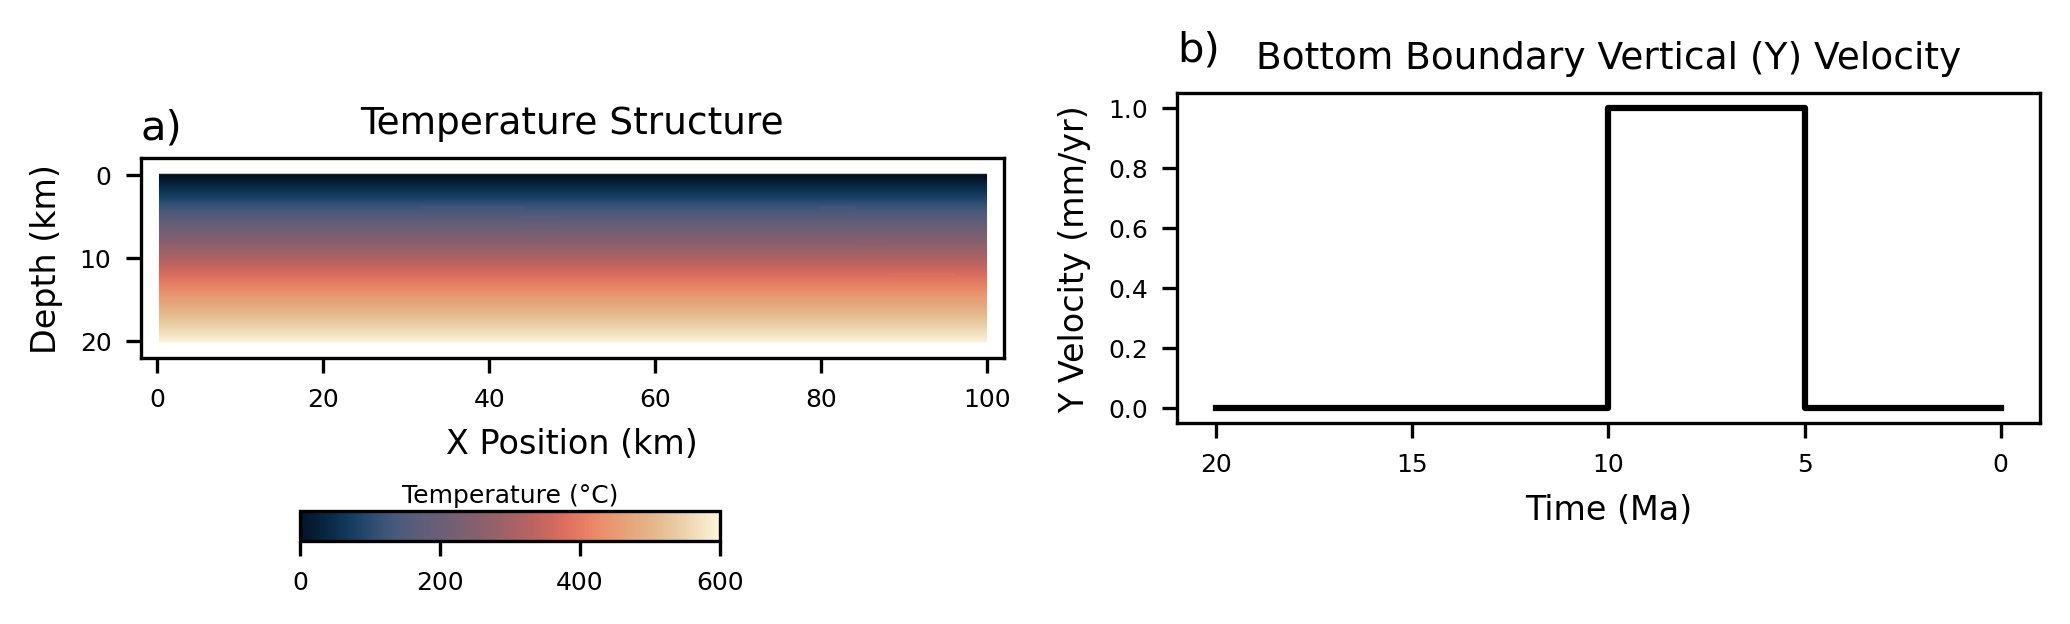

In [2]:
# Model setup figure
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(7, 2))
file = 'meshes_tchron_exhumation/meshes_tchron_exhumation_000.vtu'
mesh = pv.read(file)
mesh.points /= 1e3  # Convert to km
mesh['T'] -= 273.15  # Convert temp to °C
mesh.points[:, 1] = -(mesh.points[:, 1] - 20)  # Convert Y position to depth

clim = (0, 600)  # °C
cmap = cmc.lipari

gdt.plot_vtk_2d(mesh, 'T', bounds=[-2, 102, -2, 22], ax=axs[0],
          cmap=cmap, colorbar=False, clim=clim)

axs[0].set_title('Initial Temperature Structure', fontsize=9)
axs[0].set_xlabel('X Position (km)', fontsize=8)
axs[0].set_ylabel('Depth (km)', fontsize=8)
axs[0].invert_yaxis()

times = [20, 10, 10, 5, 5, 0]
y_vel = [0, 0, 1, 1, 0, 0]
axs[1].plot(times, y_vel, c='black')
axs[1].set_title('Bottom Boundary Vertical (Y) Velocity', fontsize=9)
axs[1].set_xlabel('Time (Ma)', fontsize=8)
axs[1].set_ylabel('Y Velocity (mm/yr)', fontsize=8)
axs[1].set_xticks([0, 5, 10, 15, 20])
axs[1].invert_xaxis()

for k, ax in enumerate(axs):
    ax.tick_params(labelsize=6)
    ax.annotate(chr(97 + k) + ')', (0, 1.1), xycoords='axes fraction', fontsize=10)

cax = fig.add_axes([0.15, 0.05, 0.2, 0.05])
norm = mcolors.Normalize(vmin=clim[0], vmax=clim[1])
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, cax=cax, orientation='horizontal')

cax.tick_params(labelsize=6)
cax.set_title('Temperature (°C)', fontsize=6, pad=2)

plt.tight_layout()
fig.savefig('exhumation_setup.pdf', bbox_inches='tight')


The cell below defines some parameters for the plot of the model results

In [3]:
# Set up parameters
bounds = [35, 65, 0, 12]  # km, X position and depth
times = [10, 5, 0]  # Ma
labels = ['Before Exhumation', 'After Exhumation', 'After Quiescence']

ahe_cmap = cmc.lapaz_r
aft_cmap = cmc.lajolla_r
zhe_cmap = cmc.bamako_r
cat_cmap = cmc.batlowS

clim = [0, 20]  # Ma
bar = False

The cell below plots a results figure showing each thermochronologic system at 10 Ma, 5 Ma, and 0 Ma. These are plotted both as views of part of the box itself and as vertical profiles through the box. It also includes relatively fine adjustements to plot layout, colorbars, lables, etc.

/tmp/ipykernel_104936/230550475.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


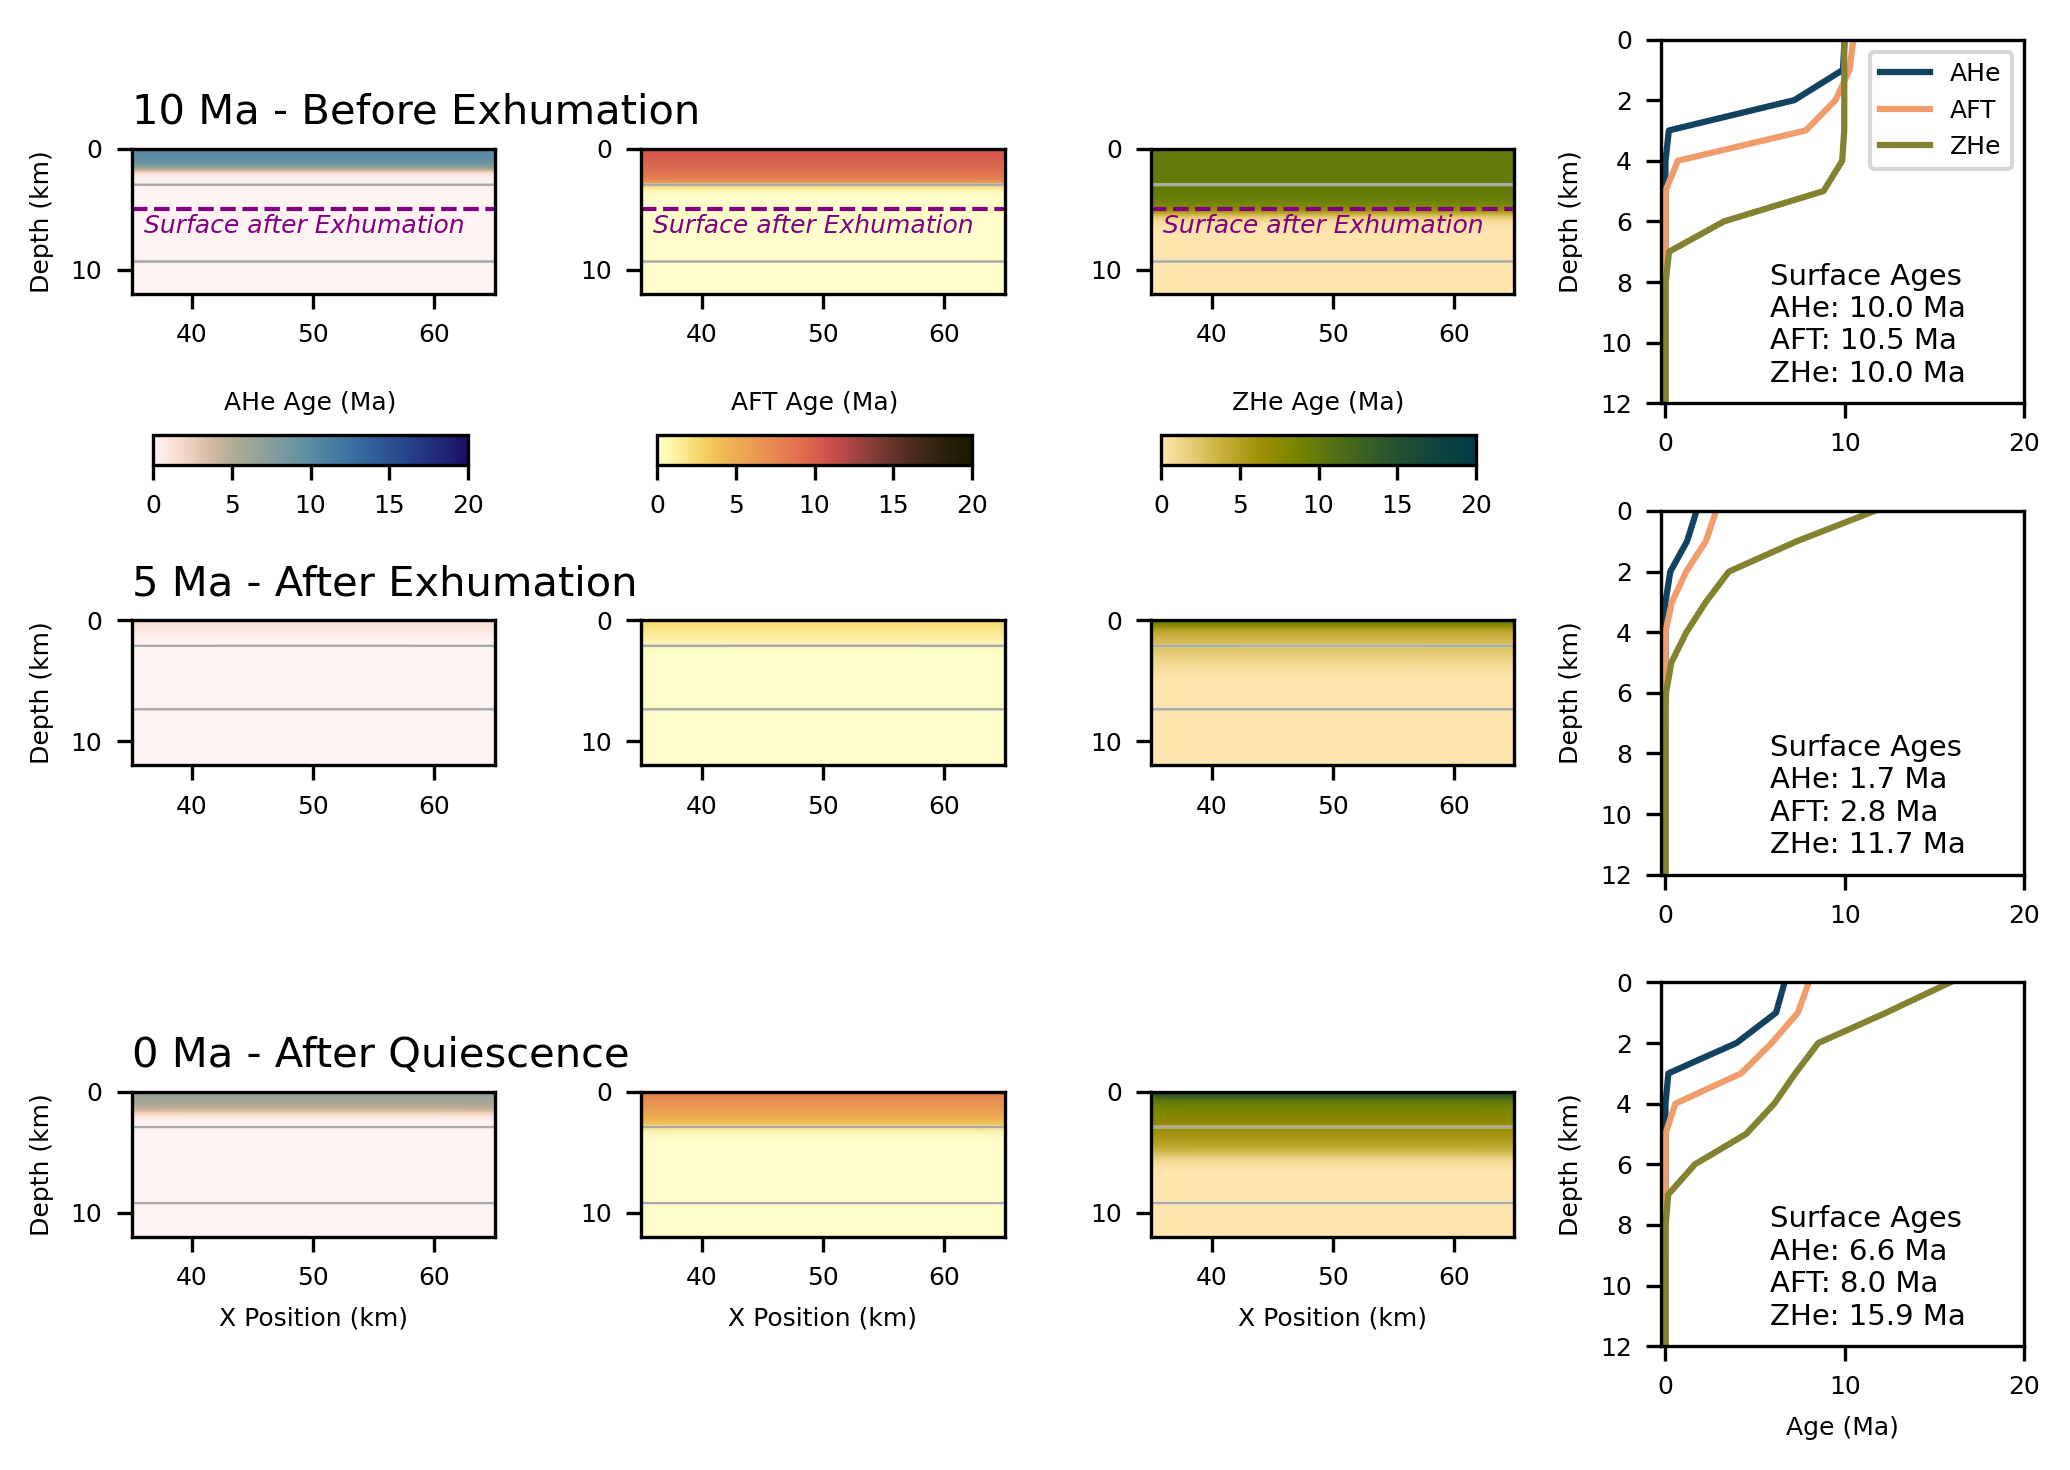

In [4]:
# Results figure
fig, axs = plt.subplots(3, 4, dpi=300, figsize=(7, 5))

for k, time_ma in enumerate(times):

    file_num = str((20 - time_ma) * 10).zfill(3)
    file = 'meshes_tchron_exhumation/meshes_tchron_exhumation_' + file_num + '.vtu'
    mesh = pv.read(file)
    mesh.points /= 1e3  # Convert to km
    mesh['T'] -= 273.15  # Convert temp to °C
    mesh.points[:, 1] = -(mesh.points[:, 1] - 20)  # Convert Y position to depth
    
    axs[k, 0].set_title(str(round(time_ma, 0)) + ' Ma - ' + labels[k], loc='left', 
                        fontsize=10)
    
    gdt.plot_vtk_2d(mesh, 'AHe', bounds=bounds, ax=axs[k, 0],
              cmap=ahe_cmap, colorbar=bar, clim=clim)
    
    gdt.plot_vtk_2d(mesh, 'AFT', bounds=bounds, ax=axs[k, 1],
            cmap=aft_cmap, colorbar=bar, clim=clim)
    
    gdt.plot_vtk_2d(mesh, 'ZHe', bounds=bounds, ax=axs[k, 2],
        cmap=zhe_cmap, colorbar=bar, clim=clim)

    # Load solution file for temperature contours
    file_num_t = file_num.zfill(5)
    file_t = 'output_exhumation_box/solution/solution-' + file_num_t + '.pvtu'
    mesh_t = pv.read(file_t)
    mesh_t.points /= 1e3  # Convert to km
    mesh_t['T'] -= 273.15  # Convert temp to °C
    mesh_t.points[:, 1] = -(mesh_t.points[:, 1] - 20)  # Convert Y position to depth
    mesh_cntrs = mesh_t.contour(isosurfaces=np.arange(100, 301, 200), scalars='T')

    for ax in axs[k, 0:3]:
        gdt.plot_vtk_2d(mesh_cntrs, None, bounds=bounds, ax=ax,
          color='dark grey', line_width=8, colorbar=True)

    y = np.round(mesh.points[:, 1], 0)

    AHe = mesh['AHe']
    AFT = mesh['AFT']
    ZHe = mesh['ZHe']

    df = pd.DataFrame({'y': y, 'AHe': AHe, 'AFT': AFT, 'ZHe': ZHe})
    df_max = df.groupby('y').agg({'y': 'first', 'AHe': 'max', 'AFT': 'max',
                                   'ZHe': 'max'})
    
    axs[k, 3].plot(df_max['AHe'], df_max['y'], c=cat_cmap.colors[6], label='AHe')
    axs[k, 3].plot(df_max['AFT'], df_max['y'], c=cat_cmap.colors[4], label='AFT')
    axs[k, 3].plot(df_max['ZHe'], df_max['y'], c=cat_cmap.colors[2], label='ZHe')

    axs[k, 3].set_xlim(-0.25, 20)
    axs[k, 3].set_ylim(bounds[2], bounds[3])
    axs[k, 3].text(0.3, -.03,
                'Surface Ages\n'
                  + 'AHe: ' + str(round(df_max['AHe'].iloc[0], 1)) + ' Ma\n'
                  + 'AFT: ' + str(round(df_max['AFT'].iloc[0], 1)) + ' Ma\n'
                  + 'ZHe: ' + str(round(df_max['ZHe'].iloc[0], 1)) + ' Ma\n',
                transform=axs[k, 3].transAxes, fontsize=7)

cax_ahe = fig.add_axes([0.08, 0.68, 0.15, 0.02])
cax_aft = fig.add_axes([0.32, 0.68, 0.15, 0.02])
cax_zhe = fig.add_axes([0.56, 0.68, 0.15, 0.02])

norm = mcolors.Normalize(vmin=clim[0], vmax=clim[1])

sm_ahe = cm.ScalarMappable(cmap=ahe_cmap, norm=norm)
sm_aft = cm.ScalarMappable(cmap=aft_cmap, norm=norm)
sm_zhe = cm.ScalarMappable(cmap=zhe_cmap, norm=norm)
sms = [sm_ahe, sm_aft, sm_zhe]

for k, cax in enumerate([cax_ahe, cax_aft, cax_zhe]):
    cax.tick_params(labelsize=6)
    plt.colorbar(sms[k], cax=cax, orientation='horizontal')

cax_ahe.set_title('AHe Age (Ma)', fontsize=6)
cax_aft.set_title('AFT Age (Ma)', fontsize=6)
cax_zhe.set_title('ZHe Age (Ma)', fontsize=6)

axs[0, 0].set_ylabel('Depth (km)', fontsize=6)
axs[1, 0].set_ylabel('Depth (km)', fontsize=6)
axs[2, 0].set_ylabel('Depth (km)', fontsize=6)

axs[2, 0].set_xlabel('X Position (km)', fontsize=6)
axs[2, 1].set_xlabel('X Position (km)', fontsize=6)
axs[2, 2].set_xlabel('X Position (km)', fontsize=6)
axs[2, 3].set_xlabel('Age (Ma)', fontsize=6)

axs[0, 3].set_ylabel('Depth (km)', fontsize=6)
axs[1, 3].set_ylabel('Depth (km)', fontsize=6)
axs[2, 3].set_ylabel('Depth (km)', fontsize=6)

axs[0, 3].legend(fontsize=6)

for ax in axs.flat:
    ax.tick_params(labelsize=6)
    ax.invert_yaxis()

for ax in axs[0, 0:3]:
    ax.axhline(5, color='purple', linestyle='--', linewidth=1)
    ax.text(36, 7, 'Surface after Exhumation', fontsize=6, color='purple', 
            style='italic')

plt.tight_layout()
fig.savefig('exhumation_results.pdf')